In [196]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from transformers import AutoTokenizer, AutoModel
import torch
import sqlite3
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
import pandas as pd
import pycaret
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import json
import random
from deap import base, creator, tools, algorithms
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [197]:
# Подключение к базе данных
conn = sqlite3.connect('../db/normalized_data.db')
cursor = conn.cursor()

df = pd.read_sql("SELECT * FROM jobs", conn)

# Закрытие соединения с базой данных
conn.close()


# Загрузка конфига
with open('../cfg/config.json', 'r', encoding="utf-8") as file:
    cfg = json.load(file)

In [198]:
filtered_df = df[df['cluster'] == 0]
sentences = filtered_df['job_name_norm'].to_list()
experience_at_start = filtered_df['experience_at_start'].to_numpy()
print(len(sentences))

4090


In [199]:
# Загрузка модели BERT
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")

# Токенизация предложений
encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=24, return_tensors='pt')

# Вычисление токенов
with torch.no_grad():
    model_output = model(**encoded_input)

In [200]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [201]:
vectorizer = TfidfVectorizer()
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])



X = sentence_embeddings.numpy()

use_persons_expirience_at_the_time_of_getting_job = cfg['use_persons_expirience_at_the_time_of_getting_job']
if use_persons_expirience_at_the_time_of_getting_job:
    scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
    experience_at_start_scaled = scaler.fit_transform(experience_at_start.reshape(-1, 1)).flatten()
    weight = cfg['expirience_at_the_time_of_getting_job']
    experience_at_start_weighted = experience_at_start_scaled * weight
    X = np.column_stack((X, experience_at_start))

In [202]:
DBSCAN_epsilon = cfg['DBSCAN_epsilon']

def evalDBSCAN(individual):
    dbscan = DBSCAN(eps=individual[0], min_samples=2)
    labels = dbscan.fit_predict(X)

    if len(set(labels)) == 1 or -1 in labels:
        return -1,
    return silhouette_score(X, labels),

if DBSCAN_epsilon is None:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    min_eps = cfg['DBSCAN_epsilon_mutation_range_min']
    max_eps = cfg['DBSCAN_epsilon_mutation_range_max']

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, min_eps, max_eps)
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.attr_float,), n=1)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", evalDBSCAN)

    # Кроссовер
    def cxMean(ind1, ind2):
        ind1[0] = (ind1[0] + ind2[0]) / 2.0
        ind2[0] = ind1[0]
        return ind1, ind2

    toolbox.register("mate", cxMean)

    def checkBounds(min, max):
        def decorator(func):
            def wrapper(*args, **kargs):
                offspring = func(*args, **kargs)
                for child in offspring:
                    if child[0] < min:
                        child[0] = min
                    elif child[0] > max:
                        child[0] = max
                return offspring
            return wrapper
        return decorator

    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
    toolbox.decorate("mutate", checkBounds(min_eps, max_eps))

    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=cfg['DBSCAN_epsilon_mutation_population'])
    ngen = cfg['DBSCAN_epsilon_mutation_gens']
    result = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=ngen, verbose=True)

    best_ind = tools.selBest(population, 1)[0]
    print(f"Найденый лучший параметр DBSCAN: eps={best_ind[0]}")

    DBSCAN_epsilon = best_ind[0]


gen	nevals
0  	50    
1  	27    
2  	30    
3  	27    
4  	27    
5  	18    
6  	28    
7  	30    
8  	27    
9  	21    
10 	36    
11 	30    
12 	21    
13 	30    
14 	30    
15 	29    
16 	25    
17 	28    
18 	24    
19 	30    
20 	33    
21 	29    
22 	36    
23 	30    
24 	28    
25 	28    
26 	23    
27 	31    
28 	28    
29 	32    
30 	39    
31 	33    
32 	27    
33 	25    
34 	33    
35 	29    
36 	24    
37 	30    
38 	32    
39 	28    
40 	28    
Найденый лучший параметр DBSCAN: eps=4.1309453219170535


In [203]:
dbscan = DBSCAN(eps=DBSCAN_epsilon, min_samples=2)
clusters = dbscan.fit_predict(X)
print(clusters)
print(max(clusters))

[  0   0   1 ... 257  71  71]
370


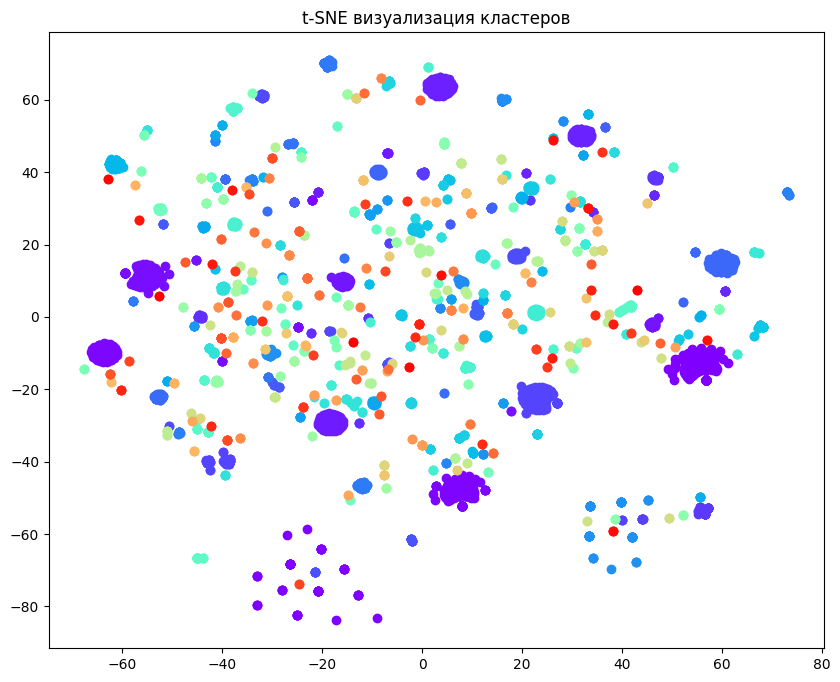

In [204]:
# Визуализация результатов (если применимо)
# Можно использовать t-SNE для снижения размерности, если X имеет больше двух измерений
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

best_n_clusters = max(clusters)

colors = plt.cm.rainbow(np.linspace(0, 1, best_n_clusters))
plt.figure(figsize=(10, 8))
for i in range(best_n_clusters):
    plt.scatter(X_tsne[clusters == i, 0], X_tsne[clusters == i, 1], color=colors[i], label=f'Cluster {i}')
plt.title('t-SNE визуализация кластеров')
plt.show()

In [205]:
# Подключение к базе данных для сохранения сниппета
db_path_norm = "../db//normalized_data.db"
conn_norm = sqlite3.connect(db_path_norm)

print(len(df))

mask = (df['cluster'] != -2) & (df['cluster'] != -3)
df.loc[mask, 'cluster'] = clusters

df.to_sql(name='clusters', con=conn_norm, if_exists='replace', index=False)

4335


4335